## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


# Course Project

## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

- The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

- Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

- Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?


## Today

Explore the dataset and do some initial statistics. 

In [5]:
import urllib
import os,sys
import numpy as np
import pandas as pd

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")

    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

table = pd.read_csv('compas-scores-two-years.csv',delimiter = ',')
#print(table.isnull())#is null checks missing values in a table, return a table of boolean

df = pd.read_csv(COMPAS_INPUT_FILE)   #df is a dataframe
print(df.keys())





df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals (NaN for sure, also null???)

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]    # Only keep the values that forfull these constraints

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
print(df)
print(df.shape)

print(df.race.drop_duplicates())
print(df.age_cat.drop_duplicates())





Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'st

## Load data and clean it up

__Load the data__

hint: data is in csv format; pandas is a python library that can read csv files

you can choose to represent your data either as a DataFrame or as a dictionary

- The dataset contains data on how many convicts? 

- What are the features the dataset contains?

hint pandas: check pandas functions shape, column, head

hint dictionary: check keys() function

In [8]:
df = pd.read_csv(COMPAS_INPUT_FILE)   #df is a dataframe

print("shape: " + str(df.shape))   # Tuple representing the dimensionality
print("index (the amount of convict = 7214) : " + str(df.index))   # The index (row labels) of the DataFrame.
print("Different features of the convicts (53): " + str(df.columns))
print("Different features of the convicts (53): " + str(df.keys())) # we can also use keys()
print("index.value_counts (???): " + str(df['race'].value_counts())) # count the unique values in a column
print("Display the first 3 rowns:" + str(df.head(5)))

table = pd.read_csv('compas-scores-two-years.csv',delimiter = ',')
print(table.isnull())#is null checks missing values in a table, return a table of boolean




shape: (7214, 53)
index (the amount of convict = 7214) : RangeIndex(start=0, stop=7214, step=1)
Different features of the convicts (53): Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'pr

__Cleanup the data__

- Are there missing values (NaN)? are there outliers?  

hint pandas: check isnull function in pandas

hint dictionary: implement a for and check if the variable is None

- Does ProPublica mentions how to clean the data?
 -> NO!

__What is the effect of the following function?__

df = pd.read_csv(COMPAS_INPUT_FILE)

print(df.shape)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

## Basic analysis of demographics

- What are the different races present in the dataset? 

In [26]:
print(df.race.drop_duplicates().values)

['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']


- What is the number of people by age category?

In [29]:
print("number of people by age category: \n" + str(df['age_cat'].value_counts())) # count the unique values in a column

number of people by age category: 
25 - 45            4109
Greater than 45    1576
Less than 25       1529
Name: age_cat, dtype: int64


- What is the number of people by race?

In [28]:
print("number of people by race: \n" + str(df['race'].value_counts())) # count the unique values in a column

number of people by race: 
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64


- What is the number of people by COMPAS score (decile_score)?

In [30]:
print("number of people by COMPAS score: \n" + str(df['decile_score'].value_counts())) # count the unique values in a column

number of people by COMPAS score: 
1     1440
2      941
4      769
3      747
5      681
6      641
7      592
8      512
9      508
10     383
Name: decile_score, dtype: int64


- What is the number of people by COMPAS risk category (score_text)?

In [31]:
print("number of people by COMPAS risk category: \n" + str(df['score_text'].value_counts())) # count the unique values in a column

number of people by COMPAS risk category: 
Low       3897
Medium    1914
High      1403
Name: score_text, dtype: int64


## Basic investigations of gender and race bias in COMPAS scores

decile_score -- is the score given by the COMPAS algorithm that estimates the risk to re-offend.

score_text -- is the level of risk: Low, Medium, High

two_years_recid -- is the ground truth data on whether the offender recidivated or not

- What is the mean COMPAS score (decile_score) per race and gender? 

In [48]:
tab = df[['decile_score','race','sex']]
stat = tab.groupby(['race', 'sex'])
print(stat.mean())

- What is the distribution (histogram) of decile_score per race and gender? 

race              sex   
African-American  Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Asian             Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Caucasian         Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Hispanic          Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Native American   Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Other             Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: decile_score, dtype: object

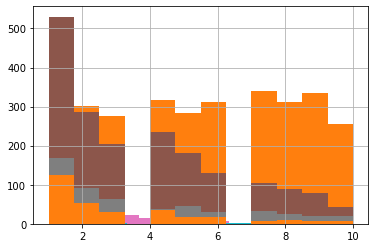

In [59]:
stat['decile_score'].hist(bins=12)

The two_year_recid field records whether or not each person was re-arrested for a violent offense within two years, which is what COMPAS is trying to predict.

- How many people were re-arrested? 

- Compute the recidivism (i.e., people that got re-arrested) rates by race and gender

- What is the accuracy of the COMPAS scores to predict recidivism

- Is the accuracy higher/lower if we look at particular races/genders?

- What about false positives and false negatives?